In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("creditcard.csv")
print(df.head())
print(df.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [4]:
print(df['Class'].value_counts()) # CHECKS CLASS IMBALANCE

Class
0    284315
1       492
Name: count, dtype: int64


# Exploratory data analysis

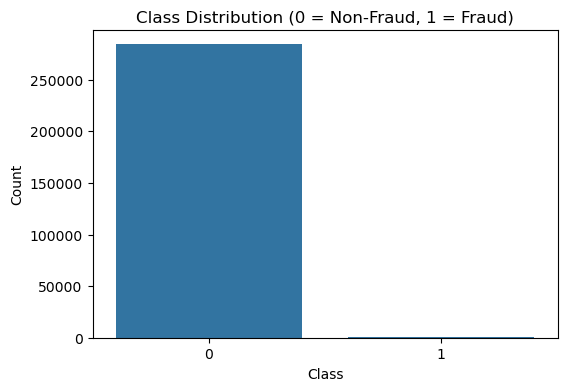

Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64


In [19]:
# plot 1: fraud vs. non-fraud

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print("Class counts:\n", df['Class'].value_counts())


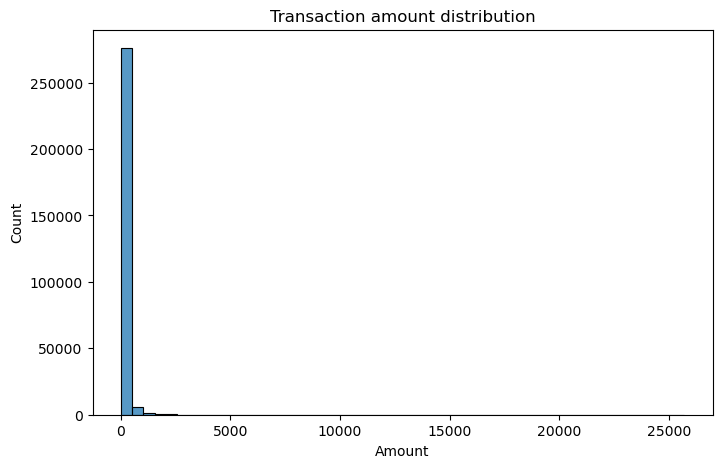

In [12]:
# plot 2 : amount distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'],bins=50)
plt.title('Transaction amount distribution')
plt.show()

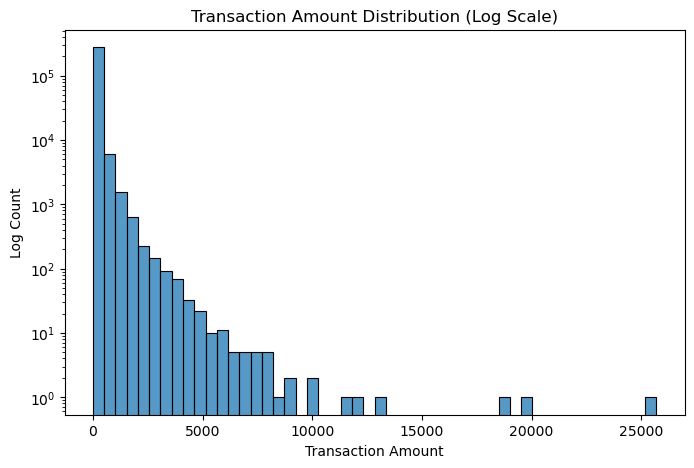

In [17]:
# plot 2 : Transaction Amount Distribution (Full Range)
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=50, kde=False)
plt.yscale('log')  # log scale to see small and large values clearly
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Transaction Amount')
plt.ylabel('Log Count')
plt.show()

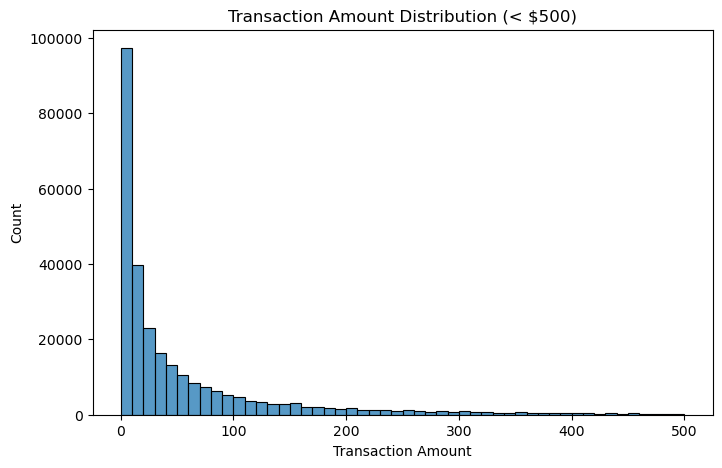

In [18]:
# Transaction Amount Distribution (Most Common Transactions)
plt.figure(figsize=(8,5))
sns.histplot(df[df['Amount'] < 500]['Amount'], bins=50, kde=False)
plt.title('Transaction Amount Distribution (< $500)')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

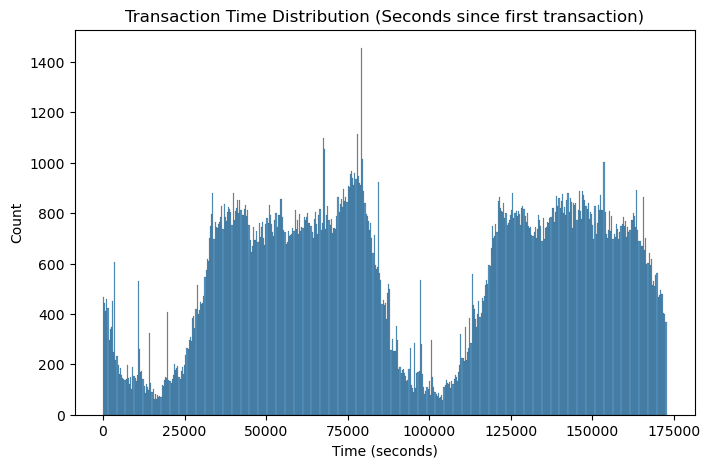

In [22]:
# PLot 3: Transaction Time Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Time'], bins=500, kde=False)
plt.title('Transaction Time Distribution (Seconds since first transaction)')
plt.xlabel('Time (seconds)')
plt.ylabel('Count')
plt.show()

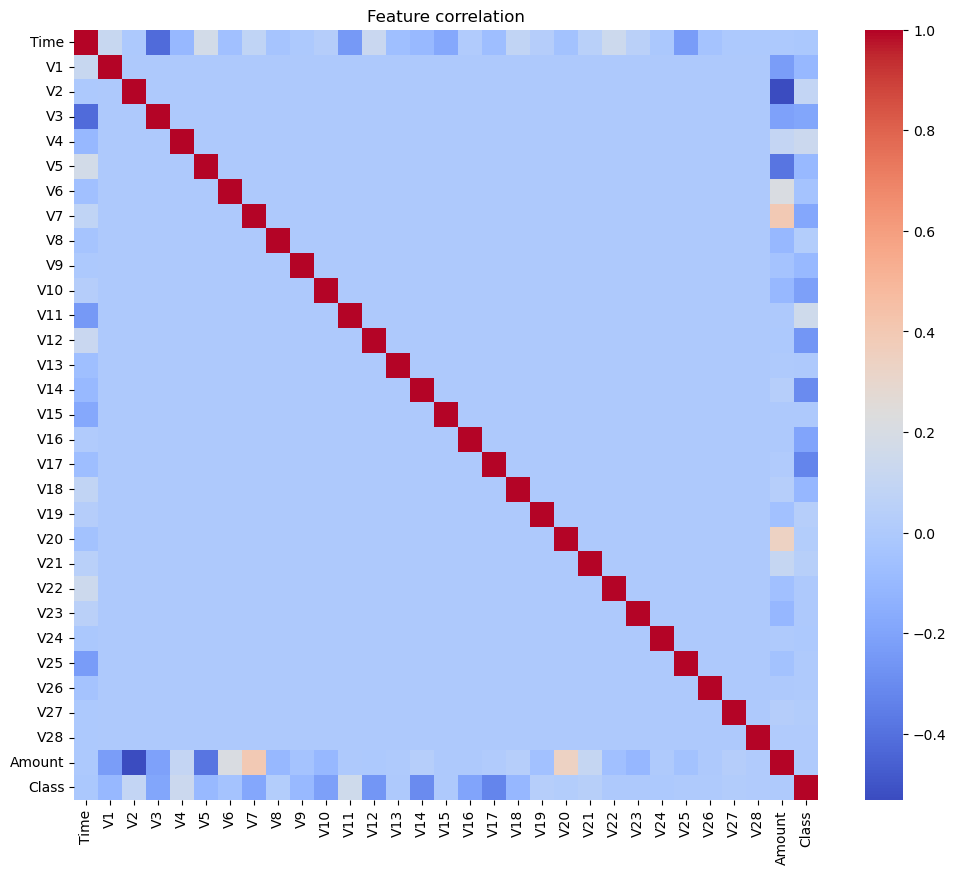

In [23]:
# Plot 4: correlation heatmap

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),cmap='coolwarm',annot=False)
plt.title('Feature correlation')
plt.show()

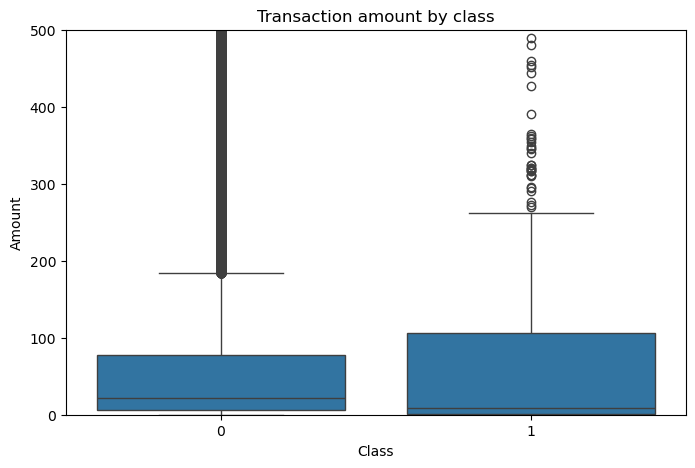

In [24]:
# Plot 5: fraud vs. non-fraud amount comparison

plt.figure(figsize=(8,5))
sns.boxplot(x='Class',y='Amount',data=df)
plt.ylim(0,500) # zoom to see most transactions
plt.title('Transaction amount by class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

# TRAINING AND TEST DATA

In [42]:
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve, precision_recall_curve, auc

In [26]:
scaler=StandardScaler()
df['Amount_scaled']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time_sclaed']=scaler.fit_transform(df['Time'].values.reshape(-1,1))

df=df.drop(['Amount','Time'],axis=1)

In [27]:
x=df.drop('Class',axis=1)
y=df['Class']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

# Handle imbalanced data

In [ ]:
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

In [30]:
sm=SMOTE(random_state=42)
x_train_res,y_train_res=sm.fit_resample(x_train,y_train)

print("before SMOTE:", y_train.value_counts())
print("after SMOTE:",pd.Series(y_train_res).value_counts())

before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
after SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


# Model training - Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [33]:
lr=LogisticRegression()
lr.fit(x_train_res,y_train_res)

y_pred_lr=lr.predict(x_test)
y_proba_lr=lr.predict_proba(x_test)[:,1]

print("Logistic Regression Classification Report:\n", classification_report(y_test,y_pred_lr))
print("ROC AUC score:",roc_auc_score(y_test,y_proba_lr))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC AUC score: 0.9698482164390798


# Model training - Random Forest

In [38]:
#smaller subset
x_train_small=x_train_res.sample(100000,random_state=42)
y_train_small=y_train_res[x_train_small.index]

rf=RandomForestClassifier(
    n_estimators=100, # moderate tree size
    max_depth=12,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(x_train_small,y_train_small)

y_pred_rf=rf.predict(x_test)
y_proba_rf=rf.predict_proba(x_test)[:,1]

print("Random Forest Classification Report:\n", classification_report(y_test,y_pred_rf))
roc_auc=roc_auc_score(y_test,y_proba_rf)
print(f"ROC AUC score:{roc_auc:.4f}")

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.48      0.87      0.62        98

    accuracy                           1.00     56962
   macro avg       0.74      0.93      0.81     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC score:0.9827


# Model training - XGBoost

In [40]:
xgb_model=xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss',scale_pos_weight=(y_train==0).sum() / (y_train==1).sum())
xgb_model.fit(x_train_res,y_train_res)

y_pred_xgb=xgb_model.predict(x_test)
y_proba_xgb=xgb_model.predict_proba(x_test)[:,1]

print("XGBoost Classification Report:\n", classification_report(y_test,y_pred_xgb))
print("ROC AUC score:",roc_auc_score(y_test,y_proba_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.86      0.60        98

    accuracy                           1.00     56962
   macro avg       0.73      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC score: 0.9776956189059754


# Evaluation using ROC & Precision Recall

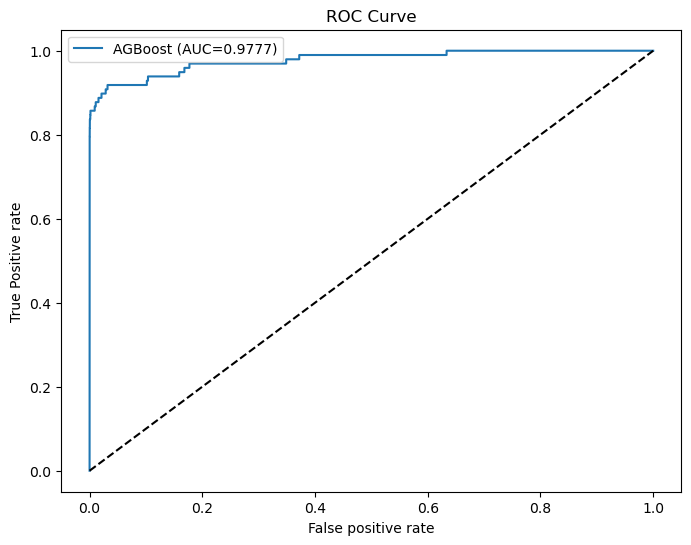

In [43]:
fpr,tpr, thresholds=roc_curve(y_test,y_proba_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label='AGBoost (AUC=%0.4F)' % roc_auc_score(y_test,y_proba_xgb))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

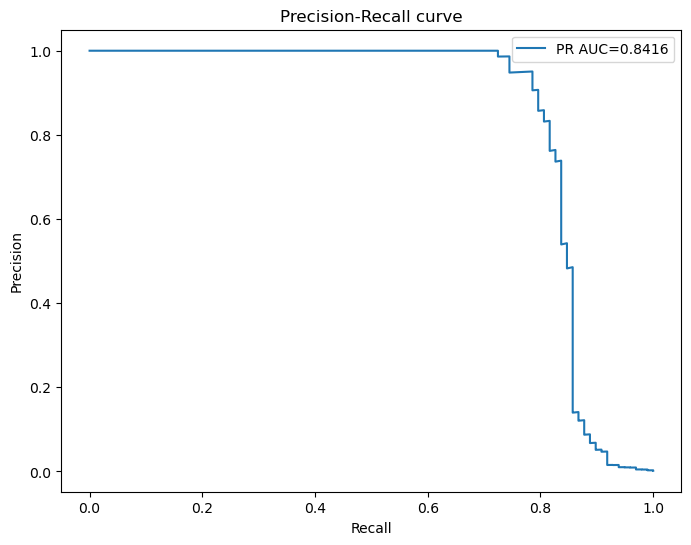

In [45]:
# precision-recall curve
precision,recall,thresholds=precision_recall_curve(y_test,y_proba_xgb)
pr_auc=auc(recall,precision)
plt.figure(figsize=(8,6))
plt.plot(recall,precision,label='PR AUC=%0.4F'%pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# Feature importance - SHAP

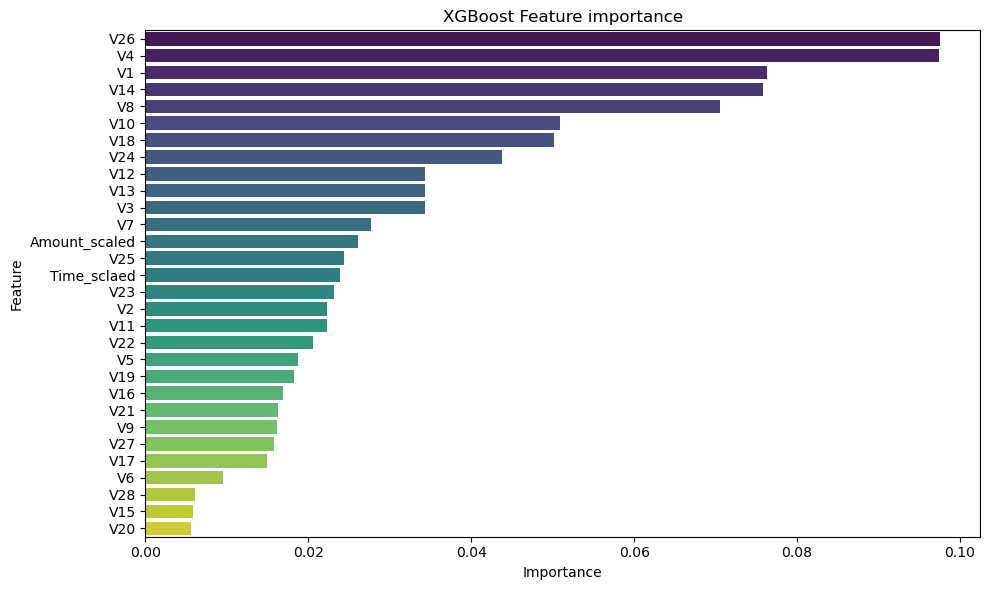

In [47]:
feature_importance=pd.DataFrame({'feature':x_train.columns,
                                 'importance':xgb_model.feature_importances_})

#sort desc
feature_importance=feature_importance.sort_values(by='importance',ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='importance',y='feature',data=feature_importance,palette='viridis')
plt.title('XGBoost Feature importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

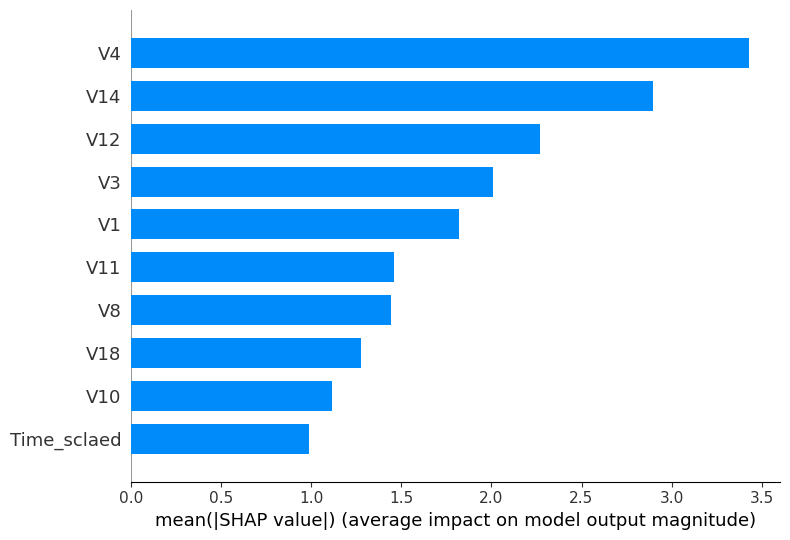

In [51]:
import shap

# Initialize explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_test)

# Summary plot
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, x_test, plot_type='bar', show=True, max_display=10)


# confusion matrix

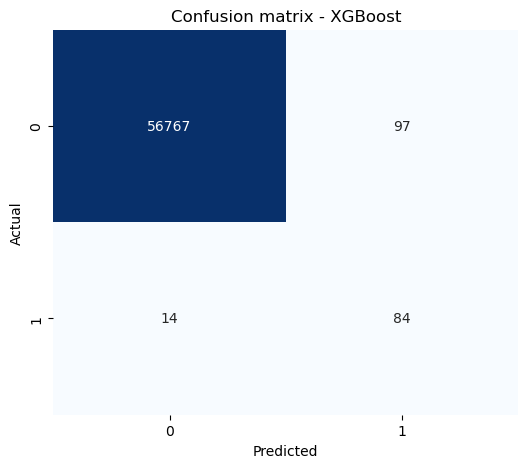

In [52]:
cm=confusion_matrix(y_test,y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.title('Confusion matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

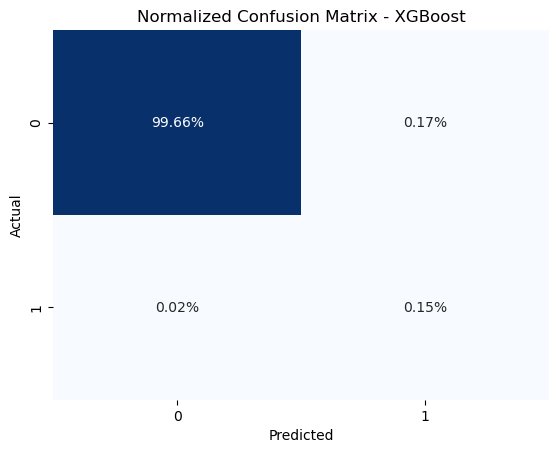

In [53]:
cm_normalized = cm.astype('float') / cm.sum()
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Normalized Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Streamlit

In [54]:
import joblib
joblib.dump(xgb_model,"credit_fraud_xgb.pkl")

['credit_fraud_xgb.pkl']

In [59]:


# X_train = your training features DataFrame
feature_means = x_train.mean()
joblib.dump(feature_means, "feature_means.pkl")


['feature_means.pkl']